# Feature Extractor on MNIST

In this notebook I'd like to use a pretrained model to extract features from the MNIST dataset. I'll use the pretrained SqueezeNet model from PyTorch's torchvision package.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [2]:
# - Let's start by loading a pretrained model (i.e. squeezenet) and modifying the last layer to classify 10 classes instead of 1000.

# read the train csv file
train_df = pd.read_csv('../datasets/digit-recognizer/train.csv')
test_df = pd.read_csv('../datasets/digit-recognizer/test.csv')

# get the labels
labels = train_df['label'].values

# drop the label column
train_df.drop('label', axis=1, inplace=True)

In [3]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 32

num_iterations = 500

# Number of iterations to train for
number_of_samples_seen = batch_size * num_iterations
print("Number of image samples to be seen: ", number_of_samples_seen)
print("total number of images: ", len(train_df))

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


Number of image samples to be seen:  16000
total number of images:  42000


In [4]:
len(train_df), len(test_df)

(42000, 28000)

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

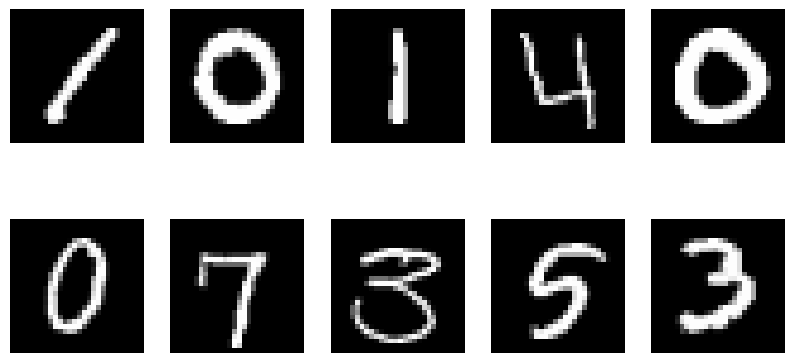

In [7]:
# get the images
images = train_df.values

# reshape the images
images = images.reshape((-1, 28, 28))

# plot some images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(images[i*5 + j], cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [8]:
# create our train and validation splits
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# convert to uint8 numpy arrays for pytorch transforms
X_train = np.asarray(X_train, dtype=np.uint8)
y_train = np.asarray(y_train, dtype=np.uint8)
X_val = np.asarray(X_val, dtype=np.uint8)
y_val = np.asarray(y_val, dtype=np.uint8)

# print shapes of train test split
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_val.shape: {y_val.shape}')

# X_train = X_train[:5000]   # TODO: use only a subset of images for training for now
# y_train = y_train[:5000]

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


In [9]:
# # # use the entire dataset for training
# X_train = np.asarray(images, dtype=np.uint8)
# y_train = torch.tensor(labels, dtype=torch.long)

In [ ]:
def get_train_val_loaders(X_train, y_train, X_val, y_val, batch_size=32):
    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    val_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = TensorDataset(torch.from_numpy(X_train), y_train)
    val_dataset = TensorDataset(torch.from_numpy(X_val), y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [10]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Update the train model function below to not use dataloaders
def train_model(model, x, y, criterion, optimizer, phases=['train', 'val'], num_iterations=num_iterations, is_inception=False):
    since = time.time()

    losses = []

    for phase in phases:
        print(f'====Phase====: {phase}')
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for i in range(num_iterations):
            # generate a batch_size of random indices
            indices = np.random.randint(0, len(x), batch_size)
            x_batch = x[indices]
            y_batch = y[indices]
            inputs = (x_batch)
            labels = (y_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate loss
                # Special case for inception because in training it has an auxiliary output. In train
                #   mode we calculate the loss by summing the final output and the auxiliary output
                #   but in testing we only consider the final output.
                if is_inception and phase == 'train':
                    # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                else:
                    outputs = model(inputs)
                    # print(f'outputs.shape: {outputs.shape}')
                    loss = criterion(outputs, labels)

                losses.append(loss.item())

                if i % 10 == 0:
                    print(f'iteration {i}: loss: {loss.item()}')

                # print(f'outputs.shape: {outputs.shape}')
                _, preds = torch.max(outputs, 1)
                # print(f'preds.shape: {preds.shape}')

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * batch_size
            # print(f'preds: {preds}')
            # print(f'labels: {labels.data}\n\n')
            running_corrects += torch.sum(preds == labels.data)

        # print(f'running_loss: {running_loss}')
        # print(f'running_corrects: {running_corrects}')
        epoch_loss = running_loss / len(x)
        epoch_acc = running_corrects.double() / (batch_size * num_iterations)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Validation Accuracy: {:4f}'.format(epoch_acc))
    
    return model, losses

In [12]:
# TODO delete cell: used for testing cell above quickly to avoid scrolling
# model_ft= train_model(model_ft, x, y, criterion, optimizer_ft, num_iterations=100)

In [13]:
# Initialize the model for this run
num_classes = 10    # 10 classes for digits 0-9 of MNIST dataset
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

/Users/sammyjaved/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sammyjaved/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Separated so in future we can do data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [16]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


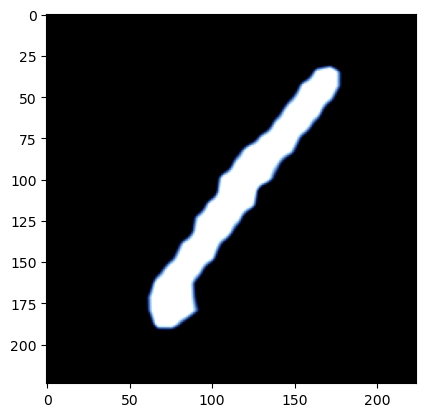

In [17]:
# plot a single transformed image
plt.imshow(data_transforms['train'](X_train[0]).permute(1, 2, 0)) # permute to convert from CxHxW to HxWxC

## Apply data transforms to the training data

In [18]:
# Apply the train data transforms on X_train
X_train = [data_transforms['train'](x_i) for x_i in X_train]

# add batch dimension to x
X_train = torch.stack(X_train)

In [ ]:
# # Train and evaluate
model_ft, losses = train_model(model_ft, X_train, y_train, criterion, optimizer_ft, ['train'])

In [ ]:
# # Save the model
torch.save(model_ft.state_dict(), 'model_ft.pth')

In [ ]:
# plot the training loss
num_batch_to_avg = 10
plt.plot(torch.tensor(losses).view(-1, num_batch_to_avg).mean(1))
plt.title("Training Loss vs Number of Batches")
plt.xlabel(f'Batch Number (averaged over {num_batch_to_avg} batches)')
plt.ylabel("Training Loss")

num_batches = num_iterations // num_batch_to_avg

### Evaluate model on a few sample images

In [ ]:
# Evaluate the model on a sample of the training set
model_ft.eval()
predictions = []
expected = []

with torch.no_grad():
    mini_batch_size = 6
    x_ = X_train[:mini_batch_size]
    y_ = y_train[:mini_batch_size]
    output = model_ft(x_)
    _, preds = torch.max(output, 1)
    predictions.append(preds)
    expected.append(y_)
    
print(f'predictions: {predictions}')
print(f'expected: {expected}')


In [ ]:
# plot some images
with torch.no_grad():
    fig, ax = plt.subplots(1, 6, figsize=(10, 5))
    for i in range(6):
        img = X_train.permute(0, 2, 3, 1)[i]
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.show()

In [ ]:
X_val

In [ ]:
# # Apply data transforms to the validation data
# X_val = [data_transforms['val'](x_i) for x_i in X_val]

# # add batch dimension to x
# X_val = torch.stack(X_val)

# Make predictions on test set

In [27]:
# Evaluate the model on the validation set
predictions = []
expected = []
phases = ['val']    # only evaluate on the validation set
# model_ft, val_losses = train_model(model_ft, X_val, y_val, criterion, optimizer_ft, phases)

In [28]:
test_images = test_df.values.reshape(-1, 28, 28)
test_images = np.asarray(test_images, dtype=np.uint8)
test_images = [data_transforms['val'](x_i) for x_i in test_images]
test_images = torch.stack(test_images)

In [ ]:

test_images.shape


In [ ]:
# Load the model
# model_ft.load_state_dict(torch.load('model_ft.pth'))

In [ ]:
len(predictions)

In [ ]:
# make predictions on the test set one image at a time
model_ft.eval()
with torch.no_grad():
    predictions = []
    stop = test_images.shape[0]
    step = 10
    for i in range(0, stop, step):
        if i % 100 == 0:
            print(f'batch {i} of {stop}')
        output = model_ft(test_images[i:i+step])
        _, preds = torch.max(output, 1)
        predictions.append(preds)

In [ ]:
flattened_predictions = [p.item() for prediction in predictions for p in prediction]
len(predictions), len(flattened_predictions)

In [ ]:
# create a submission file
submission = pd.DataFrame({'ImageId': range(1, len(flattened_predictions) + 1), 'Label': flattened_predictions})
submission.to_csv('squeezenet-feature-extract-on-mnist-submission.csv', index=False)

In [ ]:
model_ft

# Learnings and Takeaways  

- When I trained the model on all the training data for making test predictions, it performed quite poorly (43% accuracy vs when I trained on 80% of the data with 93% accuracy).  Although I trained for 3000 iterations on the entire dataset instead of 1000 , I had my doubts that the model could overfit this badly.  The bug ended up being that I had casted the images to the wrong data type when using all of the training data.  I should have casted to a numpy uint8 instead of a torch float tensor.  Here's the difference between the two:

#### np uint8 image  

```
train, test = train_test_split(mnist_train, test_size=0.2)
X_train = np.asarray(train, dtype=np.uint8)
```

- Plotting the numpy uint8 image resulted in
show image from images/npuint.png in markdown  

- ![np uint8 image](./images/np-uint8.png)  



#### torch float image  

```
train, test = train_test_split(mnist_train, test_size=0.2)
X_train = torch.tensor(train, dtype=torch.float)
```

Plotting the torch float image resulted in
![torch float image](./images/torch-float.png)  

#### Conclusion
- So converting to a torch float instead of a numpy uint8 made a huge difference because of all the clipping that happened in the former.   I was able to figure out why because I had plotted a sample image before and after any transformation was done to it
- Lesson learned: Although plotting samples to understand the data we have can seem wasteful, it can be quite useful for visual debugging, especially between any code changes that transform our data so we can ensure it's correctness

# Fine Tuning the SqueezeNet Model on MNIST

- Let's try to fine tune the SqueezeNet model on the MNIST dataset.  I'll use the same data transforms as before, but this time I'll use the pretrained model and fine tune it on the MNIST dataset.  I'll use the same training and validation split as before.  The number of parameters in the model is 1.8 million, which is quite a bit smaller than the 11 million parameters in the original SqueezeNet model.  I'll train the model for 100 iterations and see how it performs.

In [19]:
feature_extract = False

# Initialize the model for this run
num_classes = 10    # 10 classes for digits 0-9 of MNIST dataset
ft_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

In [20]:
# Send the model to GPU
ft_model = ft_model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = ft_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in ft_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in ft_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [21]:
# # Train and evaluate
ft_model, ft_losses = train_model(ft_model, X_train, y_train, criterion, optimizer_ft, ['train'])

====Phase====: train
iteration 0: loss: 2.7177114486694336
iteration 10: loss: 2.053677558898926
iteration 20: loss: 1.4439795017242432
iteration 30: loss: 0.9614105224609375
iteration 40: loss: 0.39992502331733704
iteration 50: loss: 0.5748014450073242
iteration 60: loss: 0.37766337394714355
iteration 70: loss: 0.262069433927536
iteration 80: loss: 0.3393041491508484
iteration 90: loss: 0.1504015326499939
iteration 100: loss: 0.4353618919849396
iteration 110: loss: 0.5812017917633057
iteration 120: loss: 0.21263086795806885
iteration 130: loss: 0.2753256559371948
iteration 140: loss: 0.28047919273376465
iteration 150: loss: 0.1839519888162613
iteration 160: loss: 0.12061010301113129
iteration 170: loss: 0.07180876284837723
iteration 180: loss: 0.038873665034770966
iteration 190: loss: 0.1554722934961319
iteration 200: loss: 0.19175423681735992
iteration 210: loss: 0.4869268834590912
iteration 220: loss: 0.31577274203300476
iteration 230: loss: 0.1362544149160385
iteration 240: loss: 0

In [24]:
len(ft_losses)

500

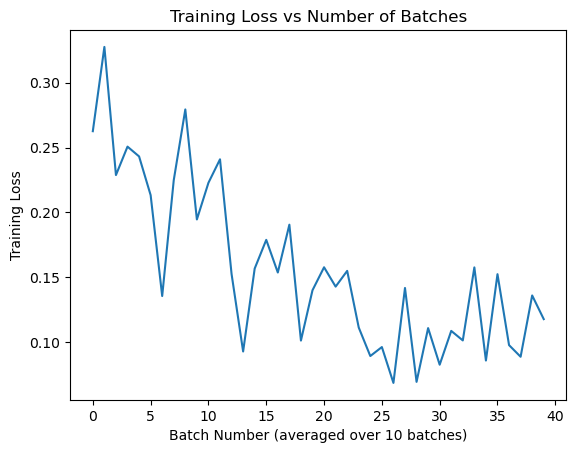

In [26]:
# plot the training loss
num_batch_to_avg = 10
plt.plot(torch.tensor(ft_losses[100:]).view(-1, num_batch_to_avg).mean(1))
plt.title("Training Loss vs Number of Batches")
plt.xlabel(f'Batch Number (averaged over {num_batch_to_avg} batches)')
plt.ylabel("Training Loss")

num_batches = num_iterations // num_batch_to_avg

In [29]:
# make predictions on the test set one image at a time
ft_model.eval()
with torch.no_grad():
    ft_predictions = []
    stop = test_images.shape[0]
    step = 10
    for i in range(0, stop, step):
        if i % 100 == 0:
            print(f'batch {i} of {stop}')
        output = ft_model(test_images[i:i+step])
        _, preds = torch.max(output, 1)
        ft_predictions.append(preds)

batch 0 of 28000
batch 100 of 28000
batch 200 of 28000
batch 300 of 28000
batch 400 of 28000
batch 500 of 28000
batch 600 of 28000
batch 700 of 28000
batch 800 of 28000
batch 900 of 28000
batch 1000 of 28000
batch 1100 of 28000
batch 1200 of 28000
batch 1300 of 28000
batch 1400 of 28000
batch 1500 of 28000
batch 1600 of 28000
batch 1700 of 28000
batch 1800 of 28000
batch 1900 of 28000
batch 2000 of 28000
batch 2100 of 28000
batch 2200 of 28000
batch 2300 of 28000
batch 2400 of 28000
batch 2500 of 28000
batch 2600 of 28000
batch 2700 of 28000
batch 2800 of 28000
batch 2900 of 28000
batch 3000 of 28000
batch 3100 of 28000
batch 3200 of 28000
batch 3300 of 28000
batch 3400 of 28000
batch 3500 of 28000
batch 3600 of 28000
batch 3700 of 28000
batch 3800 of 28000
batch 3900 of 28000
batch 4000 of 28000
batch 4100 of 28000
batch 4200 of 28000
batch 4300 of 28000
batch 4400 of 28000
batch 4500 of 28000
batch 4600 of 28000
batch 4700 of 28000
batch 4800 of 28000
batch 4900 of 28000
batch 5000 o

In [31]:
flattened_ft_predictions = [p.item() for prediction in ft_predictions for p in prediction]

# create a submission file
submission = pd.DataFrame({'ImageId': range(1, len(flattened_ft_predictions) + 1), 'Label': flattened_ft_predictions})
submission.to_csv('squeezenet-finetuned-on-mnist-submission.csv', index=False)